In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.datasets import load_digits
from __future__ import print_function

In [2]:
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
digits = load_digits()
data, target = digits.data, digits.target

In [4]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [5]:
digits.data.shape

(1797, 64)

In [6]:
print(digits.target_names)
print(digits.target)
print(digits.data)
print(data.dtype)
print(target.dtype)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 ... 8 9 8]
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
float64
int64


### Build A Preliminary Classification Tree

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

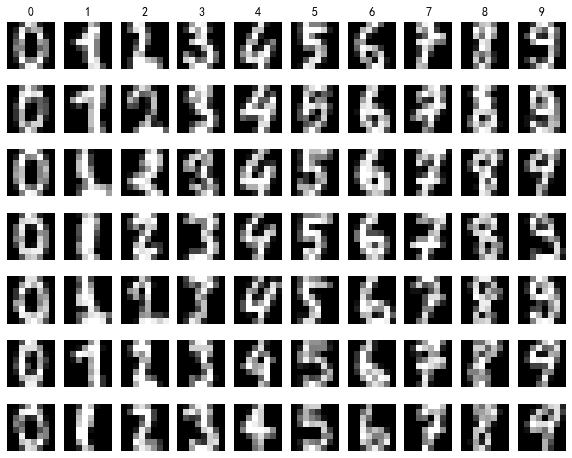

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(range(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(8, 8))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

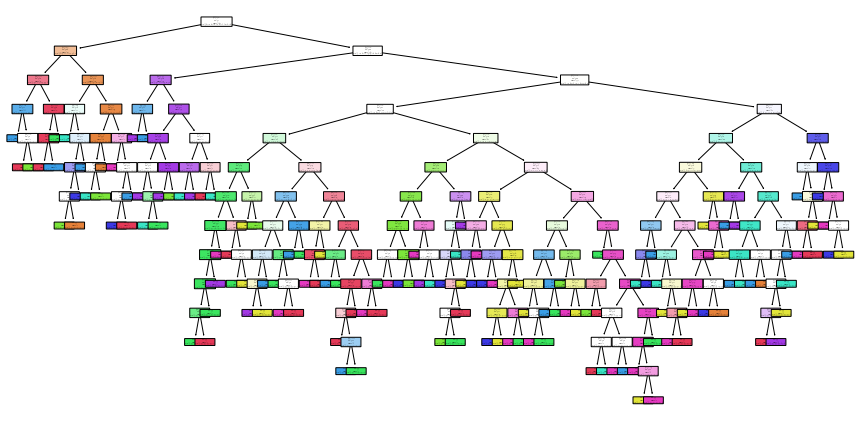

In [13]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True,
          rounded=True)
plt.show()

/home/gumiano/miniconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


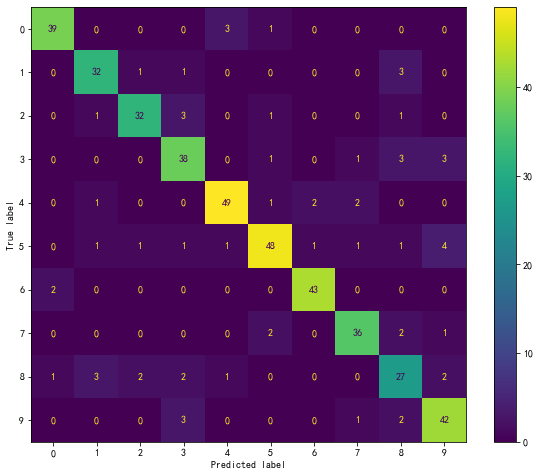

In [16]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=digits.target_names)

In [23]:
print("accuracy:", np.sum(clf_dt.predict(X_test) == y_test) / len(y_test))

accuracy: 0.8577777777777778


### Cost Complexit Pruning Part 1: Visualize alpha

One way to find th optimal value for alpha is to plot the accuracy of the tree as a funciton of different values.

We omit the maximum value for alpha with (cost complexity pruning) ccp_alphas = ccp_alphas[:-1] because it would prune all leaves, leaving us with only a root instead of a tree.

In [33]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

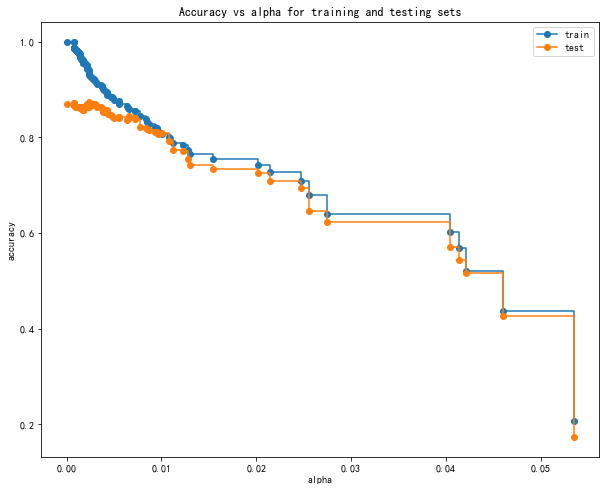

In [34]:
train_scores = [clf_dt.score(X_train ,y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

### Cost Complexity Pruning Part 2: Cross Validation For Fiding the Best Alpha

demonstrate that different traning and testing datasets result in trees with different accuracies when we set ccp_alpha=0.016

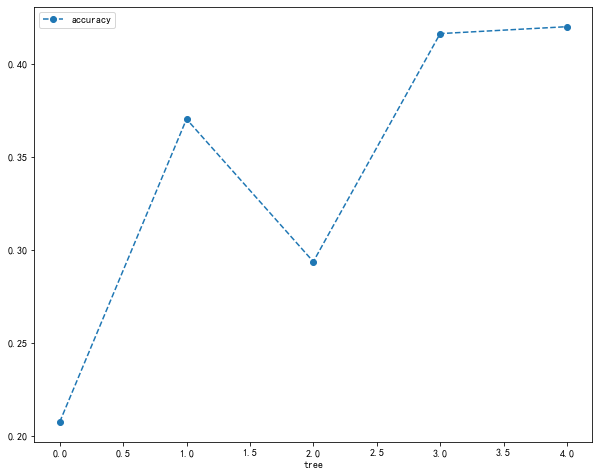

In [39]:
clt_dt = DecisionTreeClassifier(ccp_alpha=0.01)

scores = cross_val_score(clf_dt, X_train, y_train) # 默认是3~5-fold
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
plt.show()

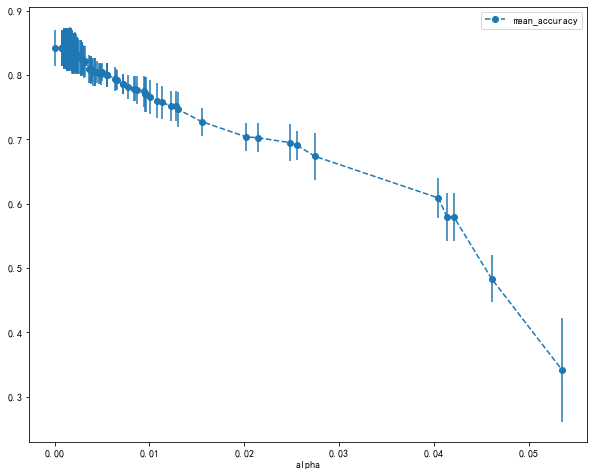

In [28]:
# create an array to store the results of each fold during cros validation
alpha_loop_values = []

# For each candidate value for alpha, we will run 5-fold cross validation 
# Then we will store the mean and standard deviation of the scores for each all 
# to cross_val_score in alpha_loop_values
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')
plt.show()

In [29]:
alpha_results[(alpha_results['alpha'] > 0.001)
              &
              (alpha_results['alpha'] < 0.003)]

,alpha,mean_accuracy,std
21,0.001114,0.841085,0.031317
22,0.001114,0.841085,0.031317
23,0.001114,0.841085,0.031317
24,0.001188,0.841085,0.031317
25,0.001188,0.841085,0.031317
26,0.001188,0.841085,0.031317
27,0.001188,0.841085,0.031317
28,0.001299,0.839598,0.032790
29,0.001336,0.839598,0.032790
30,0.001336,0.839598,0.032790


In [31]:
ideal_alpha = alpha_results[(alpha_results['alpha'] > 0.001188)
              &
              (alpha_results['alpha'] < 0.0013)]['alpha']
ideal_alpha

28    0.001299
Name: alpha, dtype: float64

In [32]:
ideal_alpha = float(ideal_alpha)
ideal_alpha # 得到了在这个训练集上拟合效果和泛化能力最好的alpha

0.0012991833704528583